In [38]:
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

import pandas as pd
import numpy as np
import datetime 

In [39]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="39288a38-ff19-432c-8011-1cd9d0dff445")
ws = Workspace(subscription_id="793146d9-d4dc-4a73-9728-76c4ffd0cc0d", resource_group="rg_dynamics_test", workspace_name="resdynml1test", auth=interactive_auth)

## Load Data

In [40]:
df_symptoms = ws.datasets['symptomcodes.csv'].to_pandas_dataframe()
df = ws.datasets['ItemResourceData.csv'].to_pandas_dataframe()

## Get last 5 years

In [41]:
# get only data from last t years
t = 5
df = df[df['Job Card.Date Start Work']>(datetime.datetime.today() - datetime.timedelta(days=t*365))]

In [42]:
len(df)

604621

## Clean nan

In [43]:
# clean data
df = df.replace(['', '0', '-', '000','N/A'], np.nan)
df = df.dropna().reset_index(drop=True)

In [44]:
len(df)

384417

In [45]:
# was für arten von fehlenden werten gib es ... beispiele

In [61]:
df[df['Job Card.JobCard Number']=='CAS-125137-B2P1Q8 JC01.00']

,Job Card.JobCard Number,ProductId,Country,City,LocationType,PostalCode,Symptoms,ProductNr,Start,End,Month,Daytime,Weekday,duration
31253,CAS-125137-B2P1Q8 JC01.00,111150290,DE,Osnabrück,Building - Business,49074,K002 K001,501033799 110623098 2136710,2019-07-01 05:00:00,2019-07-01 07:00:00,7,5,0,2.0


In [62]:
df[df['Job Card.JobCard Number']=='CAS-57422-L8N1P3 JC07.00']

,Job Card.JobCard Number,ProductId,Country,City,LocationType,PostalCode,Symptoms,ProductNr,Start,End,Month,Daytime,Weekday,duration
110551,CAS-57422-L8N1P3 JC07.00,111150095,DE,Osnabrück,Building - Administrative,49074,W001,2028266,2016-10-19 09:30:00,2016-10-19 10:00:00,10,9,2,0.5


In [46]:
df

,Installed Base.Product Group,Installed Base.InstalledBase ProductID,Job Card.JobCard Number,Location.Country,Location.City,Location.Location Type,Location.Postal Code,Product.Product Name,Product.Product Number,ItemResourceAppliedQuantity,Job Card.Date Start Work,Job Card.Date End Work,Job Card.ComponentCode,Job Card.FailureCode,Job Card.Symptom Description
0,22301,111150095,CAS-34621-Z7R3S7 JC18.00,DE,Osnabrück,Building - Administrative,49074,Lohnkosten Wartung Techniker,2028266,2,2015-11-23 07:15:00,2015-11-23 07:45:00,CSXT,CSY7,Vertragswartung
1,22301,111150095,CAS-57422-L8N1P3 JC07.00,DE,Osnabrück,Building - Administrative,49074,Lohnkosten Wartung Techniker,2028266,2,2016-10-19 09:30:00,2016-10-19 10:00:00,CSXT,CSY7,Vertragswartung
2,22301,111150095,CAS-93677-L2H9S3 JC01.00,DE,Osnabrück,Building - Administrative,49074,Lohnkosten Wartung Techniker,2028266,2,2017-11-15 11:30:00,2017-11-15 12:00:00,CSXT,CSY7,Vertragswartung
3,22301,111150095,CAS-120240-N5Z8G3 JC01.00,DE,Osnabrück,Building - Business,49074,Lohnkosten Wartung Techniker,2028266,2,2018-09-17 08:00:00,2018-09-17 08:30:00,CSXT,CSY7,Vertragswartung
4,22301,111150095,CAS-162708-W1W3T3 JC01.00,DE,Osnabrück,Building - Business,49074,Lohnkosten Wartung Techniker,2028266,2,2019-11-25 09:00:00,2019-11-25 09:30:00,CSXT,CSY7,Vertragswartung
5,22301,111150095,CAS-41672-N0N6X7 JC01.01,DE,Fröndenberg,Building - Hospital,58730,Einsatzbasisleistung,2038370,1,2016-02-01 08:00:00,2016-02-01 10:45:00,CSXT,CSY9,Messung
6,22301,111150095,CAS-41672-N0N6X7 JC01.01,DE,Fröndenberg,Building - Hospital,58730,Lohnkosten Spezialist,2028262,11,2016-02-01 08:00:00,2016-02-01 10:45:00,CSXT,CSY9,Messung
7,22301,111150095,CAS-41672-N0N6X7 JC01.01,DE,Fröndenberg,Building - Hospital,58730,Tagespauschale Messgeräte,2132712,8,2016-02-01 08:00:00,2016-02-01 10:45:00,CSXT,CSY9,Messung
8,22301,111150095,CAS-41672-N0N6X7 JC01.02,DE,Fröndenberg,Building - Hospital,58730,Einsatzbasisleistung,2038370,1,2016-02-08 08:15:00,2016-02-08 13:15:00,CSXT,CSY9,Messung
9,22301,111150095,CAS-41672-N0N6X7 JC01.02,DE,Fröndenberg,Building - Hospital,58730,Lohnkosten Spezialist,2028262,20,2016-02-08 08:15:00,2016-02-08 13:15:00,CSXT,CSY9,Messung


In [34]:
counts = df.groupby('Installed Base.InstalledBase ProductID')[['Product.Product Number']].count().reset_index()

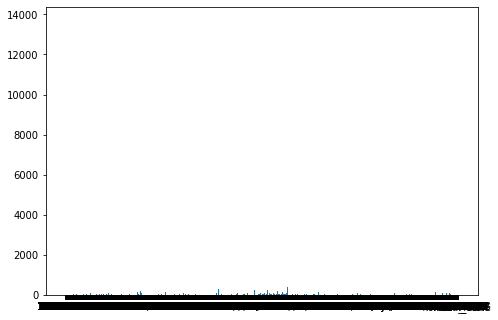

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(counts['Installed Base.InstalledBase ProductID'], counts['Product.Product Number'])
plt.show()

In [55]:
df = ws.datasets['KerasPreparedData'].to_pandas_dataframe()

In [ ]:
df

## Zuordnen von Symptomen zu vorliegenden Component-Failure-Combos

In [48]:
# combine Component/Failure Code in train data
df = pd.concat([df, pd.DataFrame(df.apply(lambda x: (x['Job Card.ComponentCode'],x['Job Card.FailureCode']), axis=1), columns=['CompFail'])], axis=1)

# combine Component/Failure Code in symptom table
df_symptoms = df_symptoms[['ComponentCode', 'FailureCode', 'Symptom1', 'Symptom2', 'Symptom3', 'Symptom4']]
df_symptoms = pd.concat([df_symptoms, pd.DataFrame(df_symptoms.apply(lambda x: (x['ComponentCode'],x['FailureCode']),axis=1), columns=['CompFail'])],axis=1)

# merge train data on symptoms
df = pd.merge(df, df_symptoms, on='CompFail', how='left')
df = pd.concat([df, pd.DataFrame(df[['Symptom1', 'Symptom2', 'Symptom3', 'Symptom4']].apply(lambda x: tuple([ x[col] for col in ['Symptom1','Symptom2','Symptom3','Symptom4'] if str(x[col]) != 'None' ]), axis=1), columns=['Symptoms'])], axis=1)

In [49]:
df[df['Job Card.JobCard Number']=='CAS-57422-L8N1P3 JC07.00']

,Installed Base.Product Group,Installed Base.InstalledBase ProductID,Job Card.JobCard Number,Location.Country,Location.City,Location.Location Type,Location.Postal Code,Product.Product Name,Product.Product Number,ItemResourceAppliedQuantity,...,Job Card.FailureCode,Job Card.Symptom Description,CompFail,ComponentCode,FailureCode,Symptom1,Symptom2,Symptom3,Symptom4,Symptoms
1,22301,111150095,CAS-57422-L8N1P3 JC07.00,DE,Osnabrück,Building - Administrative,49074,Lohnkosten Wartung Techniker,2028266,2,...,CSY7,Vertragswartung,"(CSXT, CSY7)",CSXT,CSY7,W001,None,None,None,"(W001,)"


In [13]:
len(df)

384451

In [14]:
# remove rows with no symptoms
df = df[df['Symptoms']!=()]

In [15]:
len(df)

351192

In [ ]:
# merge into one row per case
df = df.groupby('Job Card.JobCard Number').apply(lambda x: pd.Series({
    'ProductId': ' '.join(x['Installed Base.InstalledBase ProductID'].unique()),
    'Country': ' '.join(x['Location.Country'].unique()),
    'City': ' '.join(x['Location.City'].unique()),
    'LocationType': ' '.join(x['Location.Location Type'].unique()),
    'PostalCode': ' '.join(x['Location.Postal Code'].unique()),
    'Symptoms': ' '.join(map(str, list(set(x['Symptoms'].sum())))),
    'ProductNr': ' '.join(x['Product.Product Number'].unique()),
    'Start': x['Job Card.Date Start Work'].min(),
    'End': x['Job Card.Date End Work'].max(),
    'Month': str(x['Job Card.Date Start Work'].min().month),
    'Daytime': str(x['Job Card.Date Start Work'].min().hour),
    'Weekday': str(x['Job Card.Date Start Work'].min().weekday())
#     'duration': (x['Job Card.Date End Work']-x['Job Card.Date Start Work'])/3600
  })).reset_index()

###############################################################################

# compute duration column
df = pd.concat([df, pd.DataFrame((df['End'] - df['Start']), columns=['duration'])],axis=1)
df['duration'] = df['duration'].apply(lambda x: x.seconds / 3600)

In [ ]:
df.groupb